In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from bs4 import BeautifulSoup
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/santoshkhatiwada/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
df = pd.read_csv('../data/three_tweets.csv')
df.head()

,tweet_id,sentiment,author,content
0,1956967341,neutral,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,unpleasant,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,unpleasant,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,pleasant,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...


**For the classification of sentiments, we are intereseted in the content and sentiment part ony. So, we filter the dataset.**

In [15]:
columns = ['content','sentiment']
filteredDf = df[columns]
filteredDf.head()

,content,sentiment
0,@tiffanylue i know i was listenin to bad habi...,neutral
1,Layin n bed with a headache ughhhh...waitin o...,unpleasant
2,Funeral ceremony...gloomy friday...,unpleasant
3,wants to hang out with friends SOON!,pleasant
4,@dannycastillo We want to trade with someone w...,neutral


In [16]:
onehotSentiment = pd.get_dummies(filteredDf['sentiment'])
onehotSentiment.head()

,neutral,pleasant,unpleasant
0,1,0,0
1,0,0,1
2,0,0,1
3,0,1,0
4,1,0,0


**We use one hot encoding to convert the sentiments to numeric form.**

In [17]:
filteredDf= filteredDf.join(onehotSentiment)
filteredDf.head()

,content,sentiment,neutral,pleasant,unpleasant
0,@tiffanylue i know i was listenin to bad habi...,neutral,1,0,0
1,Layin n bed with a headache ughhhh...waitin o...,unpleasant,0,0,1
2,Funeral ceremony...gloomy friday...,unpleasant,0,0,1
3,wants to hang out with friends SOON!,pleasant,0,1,0
4,@dannycastillo We want to trade with someone w...,neutral,1,0,0


**The content contains some URLs and special characters. So we remove them as they are not important in describing the sentiments.**

In [43]:
#remove url in the content
filteredDf['content'] = filteredDf['content'].replace(r'http\S+', '', regex=True)
#removing the special characters like @, # ,%
removeChar = str.maketrans('', '', '&@#%')
filteredDf['content'] = [s.translate(removeChar) for s in filteredDf['content']]
stpwords = set(STOPWORDS)# removing the stop words.

In [33]:
def wordCloud(text):
    wordcloud = WordCloud(stopwords=stpwords, background_color="white",width=800,height=800).generate(text)
    return wordcloud

In [34]:
def plotWordCloud(wordcloud):
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [48]:
words = " ".join(line.strip() for line in filteredDf.content)


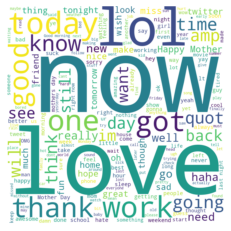

In [46]:
wordcloudAllContents = wordCloud(words)
plotWordCloud(wordcloudAllContents)

**The above wordcloud shows the common words for every sentiments.**

**Now we are going to see which words are important to describe three sentiments: neutral, pleasant and unpleasant using logistic regression.**

## Logistic Regression

In [54]:
stop_words = stopwords.words('english')
countVect = CountVectorizer(binary=False, stop_words=stop_words,
                             token_pattern="[a-zA-Z]{2,}",#only considering words which have 2 alphabets in minimum
                             min_df=5,max_df=0.95)
features = countVect.fit_transform(filteredDf.content)
allFeatures = countVect.get_feature_names()

**Since there are 3 sentiments, we use 3 logistic regressions keeping one sentiment label as 1 at a time and keeping two other labels as 0.** 

**For each label, we split the dataset into training and testing dataset and perform binary regression.**



In [82]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(features,filteredDf.neutral , test_size=0.1, random_state=6)
X_train2, X_test2, y_train2, y_test2 = train_test_split(features,filteredDf.pleasant , test_size=0.1, random_state=6)
X_train3, X_test3, y_train3, y_test3 = train_test_split(features,filteredDf.unpleasant , test_size=0.1, random_state=6)



In [115]:
def model(X_train,y_train):
    params = {
        'C':[0.07,0.09,0.1,0.2,0.3,0.5,1]
    }

    logisticModel = LogisticRegression(random_state=6,verbose=0,n_jobs=-1)
    gridSearch = GridSearchCV(logisticModel, params,verbose=3,n_jobs=-1)
    gridSearch.fit(X_train,y_train)

    return(gridSearch.best_estimator_)

In [116]:
modelNeutral = model(X_train1, y_train1)
print(modelNeutral)

Fitting 3 folds for each of 7 candidates, totalling 21 fits


/Applications/anaconda3/envs/pytorch/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2', random_state=6,
                   solver='warn', tol=0.0001, verbose=0, warm_start=False)


[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    5.3s finished
/Applications/anaconda3/envs/pytorch/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/envs/pytorch/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


In [117]:
modelPleasant = model(X_train2, y_train2)
print(modelPleasant)

/Applications/anaconda3/envs/pytorch/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    5.0s finished
/Applications/anaconda3/envs/pytorch/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/envs/pytorch/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression(C=0.3, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2', random_state=6,
                   solver='warn', tol=0.0001, verbose=0, warm_start=False)


In [118]:
modelUnpleasant = model(X_train3, y_train3)
print(modelUnpleasant)

/Applications/anaconda3/envs/pytorch/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    5.2s finished
/Applications/anaconda3/envs/pytorch/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/envs/pytorch/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression(C=0.2, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2', random_state=6,
                   solver='warn', tol=0.0001, verbose=0, warm_start=False)


In [69]:
def wordCloudFromFrequency(dictionary):
    return WordCloud(stopwords=stpwords, background_color="white",width=800,height=800).\
                                                generate_from_frequencies(dictionary)

In [119]:
trainPredict1LR = modelNeutral.predict(X_train1)
accuracyLR1train = accuracy_score(y_train1, trainPredict1LR)
print("the accuracy of training set is :{}".format(accuracyLR1train))

testPredict1LR = modelNeutral.predict(X_test1)
accuracyLR1test = accuracy_score(y_test1, testPredict1LR)
print("the accuracy of testing set is :{}".format(accuracyLR1test))

the accuracy of training set is :0.7090277777777778
the accuracy of testing set is :0.677


In [120]:
trainPredict2LR = modelPleasant.predict(X_train2)
accuracyLR2train = accuracy_score(y_train2, trainPredict2LR)
print("the accuracy of training set is :{}".format(accuracyLR2train))

testPredict2LR = modelPleasant.predict(X_test2)
accuracyLR2test = accuracy_score(y_test2, testPredict2LR)
print("the accuracy of testing set is :{}".format(accuracyLR2test))

the accuracy of training set is :0.8012222222222222
the accuracy of testing set is :0.77425


In [121]:
trainPredict3LR = modelUnpleasant.predict(X_train3)
accuracyLR3train = accuracy_score(y_train3, trainPredict3LR)
print("the accuracy of training set is :{}".format(accuracyLR3train))

testPredict3LR = modelUnpleasant.predict(X_test3)
accuracyLR3test = accuracy_score(y_test3, testPredict3LR)
print("the accuracy of testing set is :{}".format(accuracyLR3test))

the accuracy of training set is :0.7651666666666667
the accuracy of testing set is :0.71475


In [122]:
neutralEg = {}
indicesForNeutralEg = np.argsort(-1*modelNeutral.coef_)[:,0:100][0]
for i in indicesForNeutralEg[0:100]:
    neutralEg[allFeatures[i]] = modelNeutral.coef_[0,i]


In [135]:
dict(list(neutralEg.items())[0:10])

{'nope': 0.5484811767347632,
 'anybody': 0.4795637076944579,
 'finally': 0.46543407494740285,
 'ship': 0.4491786547920208,
 'coast': 0.4271834178399414,
 'surprise': 0.42064445780643106,
 'hello': 0.4197590200126482,
 'nh': 0.41364084613186786,
 'fine': 0.4110525439010851,
 'fish': 0.3988441387169546}

**The above list shows 10 top words having high feature importance responsible for classifying neutral sentiments.**

In [123]:
pleasantEg = {}
indicesForPleasantEg = np.argsort(-1*modelPleasant.coef_)[:,0:100][0]
for i in indicesForPleasantEg[0:100]:
    pleasantEg[allFeatures[i]] = modelPleasant.coef_[0,i]


In [136]:
dict(list(pleasantEg.items())[0:10])

{'loving': 1.8855307562499943,
 'excited': 1.704679337813263,
 'love': 1.5569245189144563,
 'awesome': 1.5198874483337632,
 'happy': 1.3863361621930552,
 'loved': 1.3822391378001995,
 'sweet': 1.3594495411158585,
 'amazing': 1.3508531217146869,
 'cute': 1.3421003738247357,
 'lovely': 1.3409383303307698}

**The above list shows that "loving" has more higher feature importance on classifying pleasant sentiments.**

In [124]:
unpleasantEg = {}
indicesForUnpleasantEg = np.argsort(-1*modelUnpleasant.coef_)[:,0:100][0]
for i in indicesForUnpleasantEg[0:100]:
    unpleasantEg[allFeatures[i]] = modelUnpleasant.coef_[0,i]


In [137]:
dict(list(unpleasantEg.items())[0:10])

{'sad': 2.2989716888146097,
 'hate': 1.7708508018942275,
 'hurts': 1.7165534680843524,
 'sorry': 1.5578607291454587,
 'poor': 1.5244490479321702,
 'sick': 1.5203420822197555,
 'sucks': 1.4884948411892418,
 'hurt': 1.4256255784281755,
 'sadly': 1.4223984379444081,
 'depressed': 1.3968222513020905}

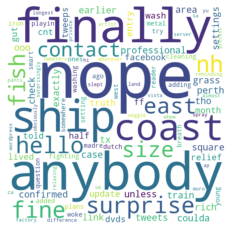

In [125]:
wordcloudNeutral = wordCloudFromFrequency(neutralEg)
plotWordCloud(wordcloudNeutral)

**The above wordcloud shows the top 100 words which are used for neutral sentiment description.**

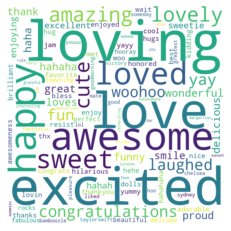

In [126]:
wordcloudPleasant = wordCloudFromFrequency(pleasantEg)
plotWordCloud(wordcloudPleasant)

**The above wordcloud shows the top 100 words used for pleasant sentiment classification.**

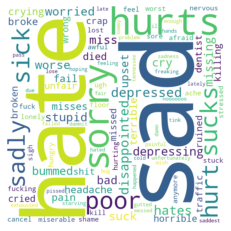

In [127]:
wordcloudUnpleasant = wordCloudFromFrequency(unpleasantEg)
plotWordCloud(wordcloudUnpleasant)

**Finally, the above wordcloud shows the top 100 words used for classifying the unpleasant sentiments.**

In [128]:
wordcloudNeutral.to_file('../reports/wordcloudTwitter/neturalUnbalanced.png')
wordcloudPleasant.to_file('../reports/wordcloudTwitter/pleasantUnbalanced.png')
wordcloudUnpleasant.to_file('../reports/wordcloudTwitter/unpleasantUnbalanced.png')